In [1]:
import build.python.pyschedlib as sc
import scripts.schedsim as sm

import os
import shutil
import matplotlib.pyplot as plt
import polars as pl
import subprocess
from concurrent.futures import ThreadPoolExecutor
from io import StringIO

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

SCHEDVIEW = "./build/apps/schedview"
sim = sm.SchedSimRunner("./build/apps/schedsim")

In [2]:
PLATFORM = "platforms/exynos5422.json"
DIR = "alloc_tasksets"
UTILIZATION = 6.5
LITTLE_PERF_SCORE = 0.33334

targets = [round(x*0.1, 1) for x in range(1, int(LITTLE_PERF_SCORE*10)+1)];
print(targets)

[0.1, 0.2, 0.3]


# Generate the tasksets

In [3]:
if os.path.isdir(DIR):
    shutil.rmtree(DIR)

os.mkdir(DIR)

util_steps = range(1, int(UTILIZATION*10)+1, 2)
NB_JOBS = 100
NB_TASK = 40
UMAX    = 0.3 #LITTLE_PERF_SCORE - 0.13334

for i in util_steps:
    data_path = f"{DIR}/{str(i)}"
    os.mkdir(data_path)
    utilization = round(i * 0.1, 1)
    print(f"jobs = {NB_JOBS}, tasks = {NB_TASK}, umax = {UMAX}, utilization = {utilization}")
    sc.generate_tasksets(data_path, NB_JOBS, NB_TASK, utilization, UMAX, success_rate = 1.0, compression_rate = 1.0, nb_cores = 8, a_special_need=(0.0, min(targets)))

print("== finished ==")

jobs = 100, tasks = 40, umax = 0.3, utilization = 0.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.5
jobs = 100, tasks = 40, umax

# Simulate the tasksets

In [4]:
alloc = "smart_ass"
sched = "grub"

for target in targets:
    print(f"-> logs_{alloc}_{sched}_{target}")
    sim.simul(DIR, alloc, sched, PLATFORM, target, f"{DIR}_logs_{alloc}_{sched}_{target}")

print("== finished ==")

-> logs_smart_ass_grub_0.1
-> logs_smart_ass_grub_0.2
-> logs_smart_ass_grub_0.3
== finished ==


-> logs_smart_ass_grub_0.3


-> logs_smart_ass_grub_0.4


-> logs_smart_ass_grub_0.5


-> logs_smart_ass_grub_0.6


# Logs analysis

In [5]:
def compute_stats(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--arrivals", "--rejected", "--deadlines-counts", "--cmigration", "--transitions", "--duration"]
    df_res = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    df_res = df_res.with_columns((pl.col("file").str.extract(r"(\w+).json").cast(pl.Int32)).alias("id")).drop("file")
    df_energy = pl.DataFrame({
        "c1-energy": [],
        "c2-energy": []
    }, schema={"c1-energy": pl.Float64, "c2-energy": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--energy"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-energy": df["energy_consumption"][0], "c2-energy": df["energy_consumption"][1]})
        df_energy = pl.concat([df_energy, df])

    df_util = pl.DataFrame({
        "c1-util": [],
        "c2-util": []
    }, schema={"c1-util": pl.Float64, "c2-util": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--util"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-util": df["util"][0], "c2-util": df["util"][1]})
        df_util = pl.concat([df_util, df])

    return pl.concat([df_res, df_energy, df_util], how="horizontal")

stats = {}
for target in targets:
    print(f"-> target {target}")
    stats[target] = {}
    stats_df = []
    util_steps = range(1, int(UTILIZATION * 10) + 1, 2)

    def compute_utilization_step(i):
        return compute_stats(f"{DIR}_logs_{alloc}_{sched}_{target}/{i}").with_columns(utilizations=i / 10)

    with ThreadPoolExecutor() as executor:
        stats_df = list(executor.map(compute_utilization_step, util_steps))

    stats[target] = pl.concat(stats_df).select(["utilizations", "id", pl.exclude(["utilizations", "id"])]).sort(["utilizations", "id"])

print("== finished ==")

-> target 0.1
-> target 0.2
-> target 0.3
== finished ==


In [6]:
results = {}
for target in targets:
    results[target] = (stats[target].with_columns(
        (1 - (pl.col("rejected") / pl.col("arrivals"))).alias("accepted-rates"),
        (1 - (pl.col("deadlines-counts") / (pl.col("arrivals") - pl.col("rejected")))).alias("meet-rates"),
        (pl.col("cmigration") / pl.col("transitions")).alias("migration-rates"),
        (pl.col("c1-energy") / pl.col("duration")).alias("c1-power"),
        (pl.col("c2-energy") / pl.col("duration")).alias("c2-power"),
        (pl.col("c1-energy") / pl.col("duration") + pl.col("c2-energy") / pl.col("duration")).alias("total-power"),
        (pl.col("c1-util") + pl.col("c2-util")).alias("total-util")
    ).group_by("utilizations").agg(
        pl.col("accepted-rates").mean(),
        pl.col("meet-rates").mean(),
        pl.col("migration-rates").mean(),
        pl.col("c1-power").mean(),
        pl.col("c2-power").mean(),
        pl.col("total-power").mean(),
        pl.col("c1-util").mean(),
        pl.col("c2-util").mean(),
        pl.col("total-util").mean()
    ))

energy = pl.concat([
  stats[target].select(["utilizations", "id", "c1-energy", "c2-energy"]).rename({"c1-energy": f"c1-energy-{str(target)}", "c2-energy": f"c2-energy-{str(target)}"}) for target in targets
], how="align")

energy_diff = energy.with_columns(
    [(pl.col(f"{clu}-energy-{target}") - pl.col(f"{clu}-energy-0.1")).alias(f"{clu}-energy-{target}-diff") for target in targets for clu in ["c1", "c2"]],
).with_columns(
    [(pl.col(f"c1-energy-{target}-diff") + pl.col(f"c2-energy-{target}-diff")).alias(f"energy-{target}-diff") for target in targets]
).group_by("utilizations").agg(
    pl.exclude(["utilizations", "id"]).mean()
)

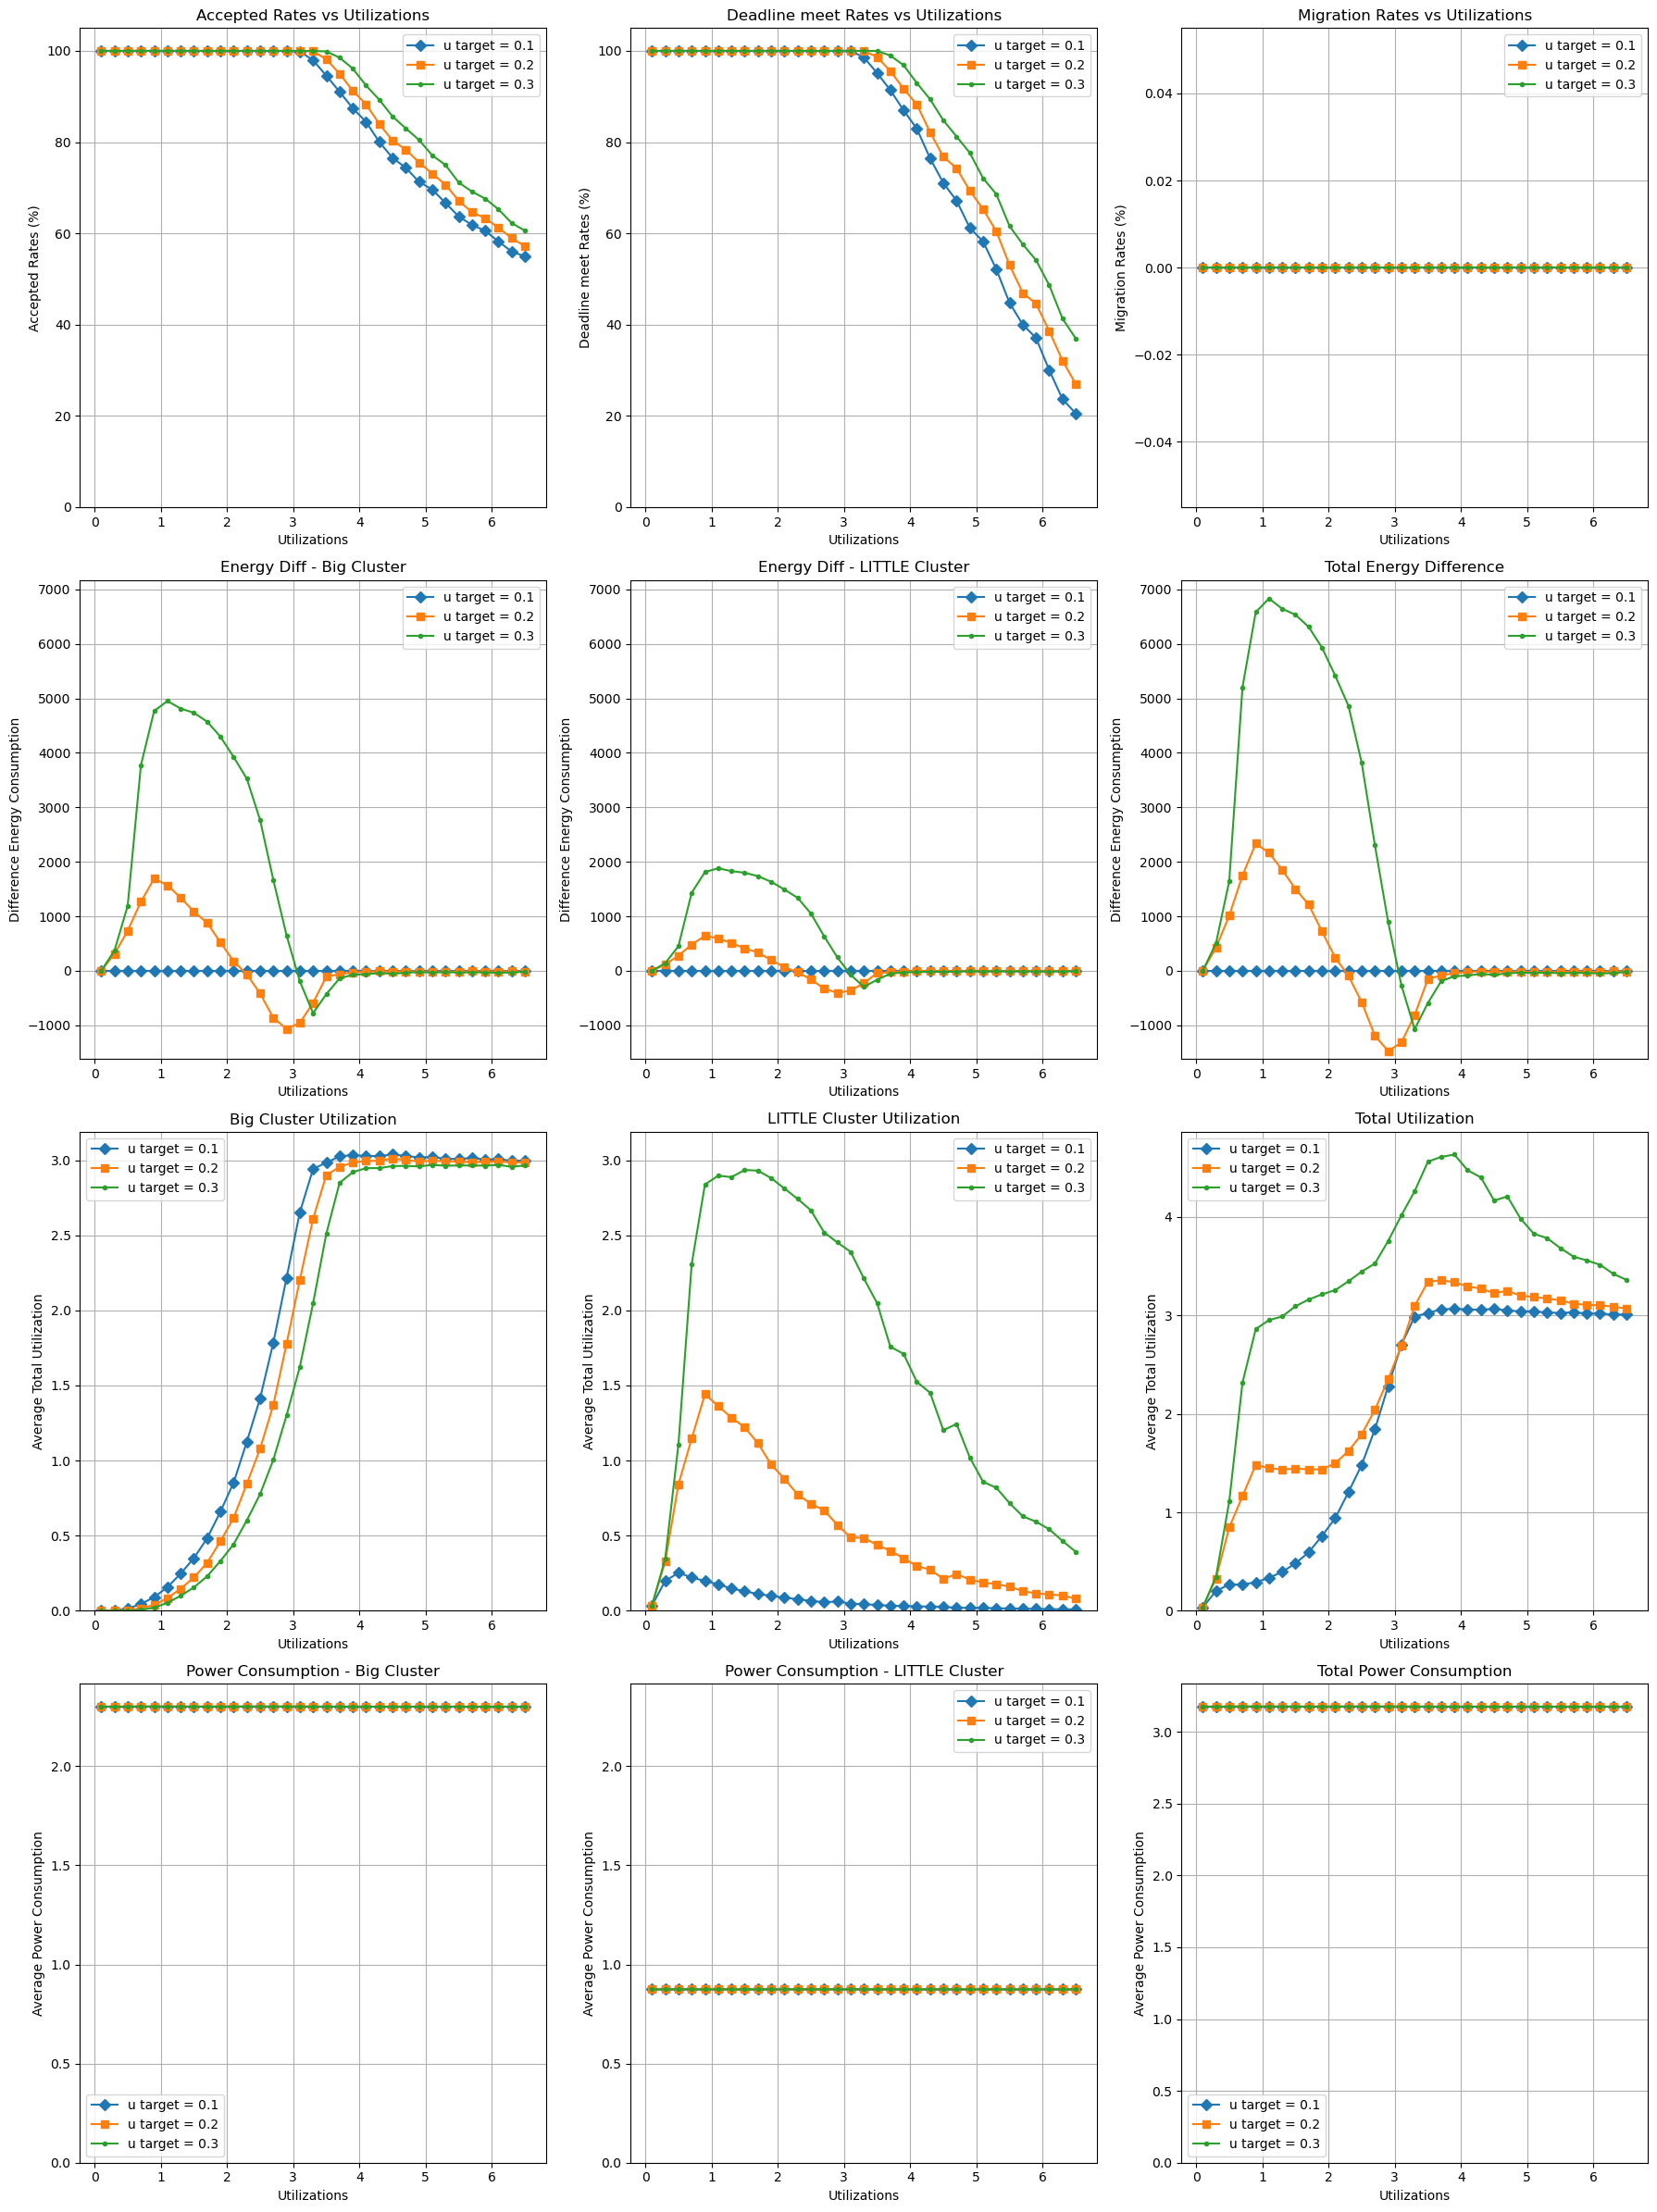

In [7]:
# Create a figure with 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# First row: Accepted Rates, Deadline Meet Rates, Migration Rates
axes[0].plot(results[0.1]["utilizations"], results[0.1]["accepted-rates"] * 100, label="u target = 0.1", marker='D')
axes[0].plot(results[0.2]["utilizations"], results[0.2]["accepted-rates"] * 100, label="u target = 0.2", marker='s')
axes[0].plot(results[0.3]["utilizations"], results[0.3]["accepted-rates"] * 100, label="u target = 0.3", marker='.')
axes[0].set_ylim(0, 105)
axes[0].set_xlabel("Utilizations")
axes[0].set_ylabel("Accepted Rates (%)")
axes[0].set_title("Accepted Rates vs Utilizations")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(results[0.1]["utilizations"], results[0.1]["meet-rates"] * 100, label="u target = 0.1", marker='D')
axes[1].plot(results[0.2]["utilizations"], results[0.2]["meet-rates"] * 100, label="u target = 0.2", marker='s')
axes[1].plot(results[0.3]["utilizations"], results[0.3]["meet-rates"] * 100, label="u target = 0.3", marker='.')
axes[1].set_ylim(0, 105)
axes[1].set_xlabel("Utilizations")
axes[1].set_ylabel("Deadline meet Rates (%)")
axes[1].set_title("Deadline meet Rates vs Utilizations")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(results[0.1]["utilizations"], results[0.1]["migration-rates"] * 100, label="u target = 0.1", marker='D')
axes[2].plot(results[0.2]["utilizations"], results[0.2]["migration-rates"] * 100, label="u target = 0.2", marker='s')
axes[2].plot(results[0.3]["utilizations"], results[0.3]["migration-rates"] * 100, label="u target = 0.3", marker='.')
axes[2].set_xlabel("Utilizations")
axes[2].set_ylabel("Migration Rates (%)")
axes[2].set_title("Migration Rates vs Utilizations")
axes[2].legend()
axes[2].grid(True)

min_y = min(energy_diff["energy-0.2-diff"].min(), energy_diff["energy-0.3-diff"].min()) * 1.10
max_y = max(energy_diff["energy-0.2-diff"].max(), energy_diff["energy-0.3-diff"].max()) * 1.05

axes[3].plot(energy_diff["utilizations"], energy_diff["c1-energy-0.1-diff"], label="u target = 0.1", marker='D')
axes[3].plot(energy_diff["utilizations"], energy_diff["c1-energy-0.2-diff"], label="u target = 0.2", marker='s')
axes[3].plot(energy_diff["utilizations"], energy_diff["c1-energy-0.3-diff"], label="u target = 0.3", marker='.')
axes[3].set_xlabel("Utilizations")
axes[3].set_ylabel("Difference Energy Consumption")
axes[3].set_title("Energy Diff - Big Cluster")
axes[3].set_ylim(min_y, max_y)
axes[3].legend()
axes[3].grid(True)

axes[4].plot(energy_diff["utilizations"], energy_diff["c2-energy-0.1-diff"], label="u target = 0.1", marker='D')
axes[4].plot(energy_diff["utilizations"], energy_diff["c2-energy-0.2-diff"], label="u target = 0.2", marker='s')
axes[4].plot(energy_diff["utilizations"], energy_diff["c2-energy-0.3-diff"], label="u target = 0.3", marker='.')
axes[4].set_xlabel("Utilizations")
axes[4].set_ylabel("Difference Energy Consumption")
axes[4].set_title("Energy Diff - LITTLE Cluster")
axes[4].set_ylim(min_y, max_y)
axes[4].legend()
axes[4].grid(True)

axes[5].plot(energy_diff["utilizations"], energy_diff["energy-0.1-diff"], label="u target = 0.1", marker='D')
axes[5].plot(energy_diff["utilizations"], energy_diff["energy-0.2-diff"], label="u target = 0.2", marker='s')
axes[5].plot(energy_diff["utilizations"], energy_diff["energy-0.3-diff"], label="u target = 0.3", marker='.')
axes[5].set_xlabel("Utilizations")
axes[5].set_ylabel("Difference Energy Consumption")
axes[5].set_title("Total Energy Difference")
axes[5].set_ylim(min_y, max_y)
axes[5].legend()
axes[5].grid(True)

axes[6].plot(results[0.1]["utilizations"], results[0.1]["c1-util"], label="u target = 0.1", marker='D')
axes[6].plot(results[0.2]["utilizations"], results[0.2]["c1-util"], label="u target = 0.2", marker='s')
axes[6].plot(results[0.3]["utilizations"], results[0.3]["c1-util"], label="u target = 0.3", marker='.')
axes[6].set_ylim(0, max([results[x]["c1-util"].max() for x in targets]) * 1.05)
axes[6].set_xlabel("Utilizations")
axes[6].set_ylabel("Average Total Utilization")
axes[6].set_title("Big Cluster Utilization")
axes[6].legend()
axes[6].grid(True)

axes[7].plot(results[0.1]["utilizations"], results[0.1]["c2-util"], label="u target = 0.1", marker='D')
axes[7].plot(results[0.2]["utilizations"], results[0.2]["c2-util"], label="u target = 0.2", marker='s')
axes[7].plot(results[0.3]["utilizations"], results[0.3]["c2-util"], label="u target = 0.3", marker='.')
axes[7].set_ylim(0, max([results[x]["c1-util"].max() for x in targets]) * 1.05)
axes[7].set_xlabel("Utilizations")
axes[7].set_ylabel("Average Total Utilization")
axes[7].set_title("LITTLE Cluster Utilization")
axes[7].legend()
axes[7].grid(True)

axes[8].plot(results[0.1]["utilizations"], results[0.1]["total-util"], label="u target = 0.1", marker='D')
axes[8].plot(results[0.2]["utilizations"], results[0.2]["total-util"], label="u target = 0.2", marker='s')
axes[8].plot(results[0.3]["utilizations"], results[0.3]["total-util"], label="u target = 0.3", marker='.')
axes[8].set_ylim(0, max([results[x]["total-util"].max() for x in targets]) * 1.05)
axes[8].set_xlabel("Utilizations")
axes[8].set_ylabel("Average Total Utilization")
axes[8].set_title("Total Utilization")
axes[8].legend()
axes[8].grid(True)

axes[9].plot(results[0.1]["utilizations"], results[0.1]["c1-power"], label="u target = 0.1", marker='D')
axes[9].plot(results[0.2]["utilizations"], results[0.2]["c1-power"], label="u target = 0.2", marker='s')
axes[9].plot(results[0.3]["utilizations"], results[0.3]["c1-power"], label="u target = 0.3", marker='.')
axes[9].set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
axes[9].set_xlabel("Utilizations")
axes[9].set_ylabel("Average Power Consumption")
axes[9].set_title("Power Consumption - Big Cluster")
axes[9].legend()
axes[9].grid(True)

axes[10].plot(results[0.1]["utilizations"], results[0.1]["c2-power"], label="u target = 0.1", marker='D')
axes[10].plot(results[0.2]["utilizations"], results[0.2]["c2-power"], label="u target = 0.2", marker='s')
axes[10].plot(results[0.3]["utilizations"], results[0.3]["c2-power"], label="u target = 0.3", marker='.')
axes[10].set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
axes[10].set_xlabel("Utilizations")
axes[10].set_ylabel("Average Power Consumption")
axes[10].set_title("Power Consumption - LITTLE Cluster")
axes[10].legend()
axes[10].grid(True)

axes[11].plot(results[0.1]["utilizations"], results[0.1]["total-power"], label="u target = 0.1", marker='D')
axes[11].plot(results[0.2]["utilizations"], results[0.2]["total-power"], label="u target = 0.2", marker='s')
axes[11].plot(results[0.3]["utilizations"], results[0.3]["total-power"], label="u target = 0.3", marker='.')
axes[11].set_ylim(0, max([results[x]["total-power"].max() for x in targets]) * 1.05)
axes[11].set_xlabel("Utilizations")
axes[11].set_ylabel("Average Power Consumption")
axes[11].set_title("Total Power Consumption")
axes[11].legend()
axes[11].grid(True)

plt.tight_layout()
plt.show()